In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

In [3]:
from utils.helper import *

In [4]:
df = pd.read_csv("../../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

In [5]:
target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

df = scaled_data(df)

seq_len = 5
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

/Users/sohamsamal/Documents/Coding/Research/research-btc-pred/venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

In [7]:
# torch.Size([256, 5, 14]) -> [B, T, F]
# torch.Size([256])        -> [B]

class BaselineLSTM(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, dropout=0.2):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden1, batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(input_size=hidden1, hidden_size=hidden2, batch_first=True)
        self.fc = nn.Linear(hidden2, 1)

    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.lstm1(x)
        out = self.drop1(out)
        out, _ = self.lstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)    # (B,)

In [8]:
lstm = BaselineLSTM(input_dim=len(features))

# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

In [9]:
# Training the model using the train_loader, val_loader, and test_loader
lstm = lstm.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

num_epochs = 300
best_val_loss = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in lstm.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    lstm.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = lstm(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    lstm.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = lstm(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(lstm.state_dict(), '../../models/temp_models/lstm5.pth')
    else:
        patience_counter += 1

    # if epoch % 10 == 0 or epoch == num_epochs - 1:
    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_val_loss:.6f}')

Training on device: mps
Model parameters: 33057
Epoch 1/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 69.13it/s]


Epoch [1/300] - Train Loss: 1.059624, Val Loss: 18.429733
Epoch 2/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 405.85it/s]


Epoch [2/300] - Train Loss: 0.870548, Val Loss: 16.993988
Epoch 3/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 442.69it/s]


Epoch [3/300] - Train Loss: 0.705143, Val Loss: 15.186434
Epoch 4/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 435.82it/s]


Epoch [4/300] - Train Loss: 0.560932, Val Loss: 13.100414
Epoch 5/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 336.18it/s]


Epoch [5/300] - Train Loss: 0.465590, Val Loss: 10.854066
Epoch 6/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 438.41it/s]


Epoch [6/300] - Train Loss: 0.377722, Val Loss: 8.685473
Epoch 7/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 462.85it/s]


Epoch [7/300] - Train Loss: 0.294466, Val Loss: 6.823386
Epoch 8/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 462.08it/s]


Epoch [8/300] - Train Loss: 0.216740, Val Loss: 5.249071
Epoch 9/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 391.22it/s]


Epoch [9/300] - Train Loss: 0.163167, Val Loss: 3.897014
Epoch 10/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 449.65it/s]


Epoch [10/300] - Train Loss: 0.123893, Val Loss: 2.821467
Epoch 11/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 442.69it/s]


Epoch [11/300] - Train Loss: 0.097501, Val Loss: 2.107397
Epoch 12/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 396.36it/s]


Epoch [12/300] - Train Loss: 0.078756, Val Loss: 1.659404
Epoch 13/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 304.56it/s]


Epoch [13/300] - Train Loss: 0.066195, Val Loss: 1.341780
Epoch 14/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 412.52it/s]


Epoch [14/300] - Train Loss: 0.056547, Val Loss: 1.157784
Epoch 15/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 478.83it/s]


Epoch [15/300] - Train Loss: 0.049720, Val Loss: 1.015373
Epoch 16/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 439.01it/s]


Epoch [16/300] - Train Loss: 0.043812, Val Loss: 0.939746
Epoch 17/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 474.60it/s]


Epoch [17/300] - Train Loss: 0.040689, Val Loss: 0.806338
Epoch 18/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 412.70it/s]


Epoch [18/300] - Train Loss: 0.039533, Val Loss: 0.807695
Epoch 19/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 363.05it/s]


Epoch [19/300] - Train Loss: 0.042763, Val Loss: 0.644473
Epoch 20/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 483.44it/s]


Epoch [20/300] - Train Loss: 0.035816, Val Loss: 0.736702
Epoch 21/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 427.62it/s]


Epoch [21/300] - Train Loss: 0.030624, Val Loss: 0.595861
Epoch 22/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 410.74it/s]


Epoch [22/300] - Train Loss: 0.024715, Val Loss: 0.635794
Epoch 23/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 448.35it/s]


Epoch [23/300] - Train Loss: 0.021974, Val Loss: 0.564145
Epoch 24/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 460.94it/s]


Epoch [24/300] - Train Loss: 0.019692, Val Loss: 0.541671
Epoch 25/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 450.25it/s]


Epoch [25/300] - Train Loss: 0.017926, Val Loss: 0.512902
Epoch 26/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 454.96it/s]


Epoch [26/300] - Train Loss: 0.017325, Val Loss: 0.488220
Epoch 27/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 369.01it/s]


Epoch [27/300] - Train Loss: 0.015388, Val Loss: 0.474887
Epoch 28/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 461.57it/s]


Epoch [28/300] - Train Loss: 0.014157, Val Loss: 0.457584
Epoch 29/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 429.44it/s]


Epoch [29/300] - Train Loss: 0.013522, Val Loss: 0.455337
Epoch 30/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 403.88it/s]


Epoch [30/300] - Train Loss: 0.013060, Val Loss: 0.449785
Epoch 31/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 461.88it/s]


Epoch [31/300] - Train Loss: 0.011858, Val Loss: 0.450190
Epoch 32/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 459.27it/s]


Epoch [32/300] - Train Loss: 0.012214, Val Loss: 0.440193
Epoch 33/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 452.80it/s]


Epoch [33/300] - Train Loss: 0.015156, Val Loss: 0.451833
Epoch 34/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 119.85it/s]


Epoch [34/300] - Train Loss: 0.029692, Val Loss: 0.463933
Epoch 35/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 483.77it/s]


Epoch [35/300] - Train Loss: 0.059965, Val Loss: 0.699054
Epoch 36/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 406.94it/s]


Epoch [36/300] - Train Loss: 0.050803, Val Loss: 0.562485
Epoch 37/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 391.92it/s]


Epoch [37/300] - Train Loss: 0.017118, Val Loss: 0.504468
Epoch 38/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 393.00it/s]


Epoch [38/300] - Train Loss: 0.015359, Val Loss: 0.547133
Epoch 39/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 437.54it/s]


Epoch [39/300] - Train Loss: 0.011485, Val Loss: 0.456010
Epoch 40/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 435.93it/s]


Epoch [40/300] - Train Loss: 0.010131, Val Loss: 0.462134
Epoch 41/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 453.00it/s]


Epoch [41/300] - Train Loss: 0.009352, Val Loss: 0.449825
Epoch 42/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 453.44it/s]


Epoch [42/300] - Train Loss: 0.008225, Val Loss: 0.427157
Epoch 43/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 425.08it/s]


Epoch [43/300] - Train Loss: 0.008127, Val Loss: 0.418184
Epoch 44/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 416.39it/s]


Epoch [44/300] - Train Loss: 0.007710, Val Loss: 0.417728
Epoch 45/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 512.28it/s]


Epoch [45/300] - Train Loss: 0.007454, Val Loss: 0.407688
Epoch 46/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 417.12it/s]


Epoch [46/300] - Train Loss: 0.007262, Val Loss: 0.404185
Epoch 47/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 419.37it/s]


Epoch [47/300] - Train Loss: 0.007252, Val Loss: 0.399682
Epoch 48/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 430.74it/s]


Epoch [48/300] - Train Loss: 0.006677, Val Loss: 0.399779
Epoch 49/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 462.85it/s]


Epoch [49/300] - Train Loss: 0.006811, Val Loss: 0.398682
Epoch 50/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 329.65it/s]


Epoch [50/300] - Train Loss: 0.006426, Val Loss: 0.397584
Epoch 51/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 467.85it/s]


Epoch [51/300] - Train Loss: 0.006246, Val Loss: 0.402400
Epoch 52/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 361.27it/s]


Epoch [52/300] - Train Loss: 0.006165, Val Loss: 0.400671
Epoch 53/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 393.63it/s]


Epoch [53/300] - Train Loss: 0.006366, Val Loss: 0.395602
Epoch 54/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 450.64it/s]


Epoch [54/300] - Train Loss: 0.005630, Val Loss: 0.402449
Epoch 55/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 432.00it/s]


Epoch [55/300] - Train Loss: 0.005957, Val Loss: 0.394180
Epoch 56/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 280.04it/s]


Epoch [56/300] - Train Loss: 0.005591, Val Loss: 0.393622
Epoch 57/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 402.74it/s]


Epoch [57/300] - Train Loss: 0.005596, Val Loss: 0.388389
Epoch 58/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 443.65it/s]


Epoch [58/300] - Train Loss: 0.005715, Val Loss: 0.384324
Epoch 59/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 336.19it/s]


Epoch [59/300] - Train Loss: 0.005772, Val Loss: 0.400658
Epoch 60/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 377.78it/s]


Epoch [60/300] - Train Loss: 0.005373, Val Loss: 0.388700
Epoch 61/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 444.36it/s]


Epoch [61/300] - Train Loss: 0.005401, Val Loss: 0.399372
Epoch 62/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 452.51it/s]


Epoch [62/300] - Train Loss: 0.005096, Val Loss: 0.390958
Epoch 63/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 385.28it/s]


Epoch [63/300] - Train Loss: 0.005619, Val Loss: 0.375422
Epoch 64/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 297.39it/s]


Epoch [64/300] - Train Loss: 0.006015, Val Loss: 0.416067
Epoch 65/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 447.73it/s]


Epoch [65/300] - Train Loss: 0.005692, Val Loss: 0.381089
Epoch 66/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 432.80it/s]


Epoch [66/300] - Train Loss: 0.005961, Val Loss: 0.417444
Epoch 67/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 318.41it/s]


Epoch [67/300] - Train Loss: 0.007240, Val Loss: 0.393036
Epoch 68/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 443.84it/s]


Epoch [68/300] - Train Loss: 0.009835, Val Loss: 0.454343
Epoch 69/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 404.52it/s]


Epoch [69/300] - Train Loss: 0.012708, Val Loss: 0.414474
Epoch 70/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 420.08it/s]


Epoch [70/300] - Train Loss: 0.015807, Val Loss: 0.484759
Epoch 71/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.74it/s]


Epoch [71/300] - Train Loss: 0.014932, Val Loss: 0.463003
Epoch 72/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 361.81it/s]


Epoch [72/300] - Train Loss: 0.010282, Val Loss: 0.423588
Epoch 73/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 400.47it/s]

Epoch [73/300] - Train Loss: 0.008364, Val Loss: 0.425249
Early stopping triggered after epoch 73

Best validation loss: 0.375422


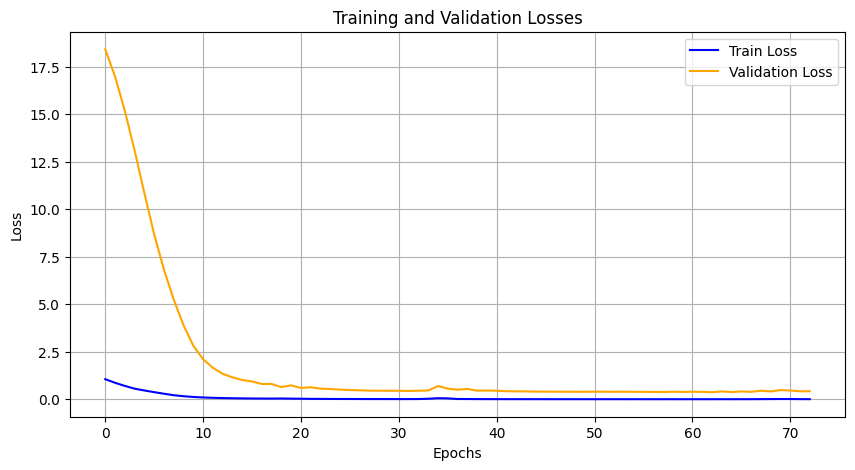

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [12]:
lstm.load_state_dict(torch.load('../../models/temp_models/lstm5.pth'))

<All keys matched successfully>

In [13]:
# Test phase
lstm.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = lstm(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.197822


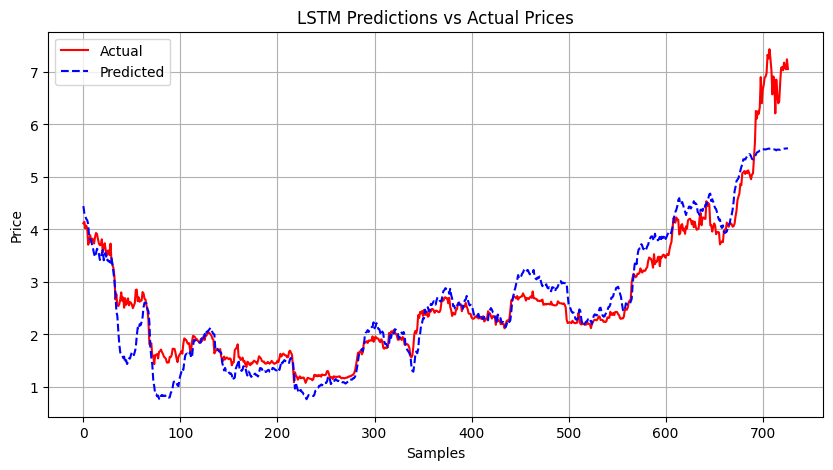

In [14]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()